# Vehicle Detection and Counting using YOLOv8

This notebook implements a vehicle detection and counting system using YOLOv8. The model will:
1. Detect vehicles in traffic images
2. Classify them as either cars ('mobil') or motorcycles ('motor')
3. Count total vehicles and per-category counts
4. Visualize the results with bounding boxes and counts

# 1. Setup and Dependencies

First, let's install and import all required libraries

In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from pathlib import Path

# Check if CUDA is available
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

CUDA available: False
Using CPU


In [2]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install ultralytics onnx onnxruntime

  Using cached onnx-1.19.0-cp311-cp311-win_amd64.whl.metadata (7.2 kB)
Using cached onnx-1.19.0-cp311-cp311-win_amd64.whl (16.5 MB)


ERROR: Could not install packages due to an OSError: [WinError 206] The filename or extension is too long: 'C:\\Users\\HP\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\onnx\\backend\\test\\data\\node\\test_attention_4d_with_past_and_present_qk_matmul_bias_3d_mask_causal\\test_data_set_0'



# 2. Load and Preprocess Dataset

Let's load our dataset configuration and examine its structure

In [7]:
# Set paths
DATASET_PATH = Path("vehicle-detection.v21i.yolov11")
DATA_YAML = DATASET_PATH / "data.yaml"

# Load and display dataset configuration
import yaml
with open(DATA_YAML, 'r') as f:
    data_config = yaml.safe_load(f)
    
print("Dataset Configuration:")
print(f"Number of classes: {data_config['nc']}")
print(f"Class names: {data_config['names']}")
print("\nData splits:")
print(f"Training: {data_config['train']}")
print(f"Validation: {data_config['val']}")
print(f"Testing: {data_config['test']}")

Dataset Configuration:
Number of classes: 2
Class names: ['mobil', 'motor']

Data splits:
Training: ../train/images
Validation: ../valid/images
Testing: ../test/images


# 3. Configure YOLO Model

Now we'll set up the YOLOv8 model with appropriate configuration for our vehicle detection task

In [8]:
# Initialize YOLO model with trained weights
model = YOLO('saved_models/vehicle_detector.pt')  # Load your trained model


# 4. Train YOLO Model

Let's train our model on the vehicle dataset

In [ ]:
# Skipping training - model is loaded from saved weights above
# model.args.update({'save_period': -1})  # Disable model saving during training
# results = model.train()

engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=vehicle-detection.v21i.yolov11\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train6, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=2, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=None, rect=False, resume=False

# 5. Vehicle Detection and Counting Functions

Let's implement functions to process the model outputs and count vehicles by type

In [10]:
def process_detections(results, conf_threshold=0.25):
    """
    Process YOLO detection results and count vehicles by type
    """
    counts = {
        'mobil': 0,  # cars
        'motor': 0,  # motorcycles
        'total': 0
    }
    
    # Process each detection
    for r in results:
        boxes = r.boxes
        for box in boxes:
            # Get confidence score
            conf = float(box.conf)
            if conf < conf_threshold:
                continue
                
            # Get class id and increment counter
            cls = int(box.cls)
            class_name = data_config['names'][cls]
            counts[class_name] += 1
            counts['total'] += 1
            
    return counts

def draw_detections(image, results, counts, conf_threshold=0.25):
    """
    Draw bounding boxes and labels on the image
    """
    # Make a copy of the image
    img = image.copy()
    
    # Colors for different classes (BGR format)
    colors = {
        'mobil': (0, 255, 0),  # Green for cars
        'motor': (255, 0, 0)   # Blue for motorcycles
    }
    
    # Draw detections
    for r in results:
        boxes = r.boxes
        for box in boxes:
            # Get confidence score
            conf = float(box.conf)
            if conf < conf_threshold:
                continue
                
            # Get box coordinates and class
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cls = int(box.cls)
            class_name = data_config['names'][cls]
            
            # Draw bounding box
            color = colors[class_name]
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            
            # Add label
            label = f"{class_name} {conf:.2f}"
            cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    # Add count summary
    summary = f"Total: {counts['total']} | Cars: {counts['mobil']} | Motorcycles: {counts['motor']}"
    cv2.putText(img, summary, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    return img

# 6. Model Inference and Visualization

Let's test our model on some images from the test set

In [11]:
def process_image(image_path, model, conf_threshold=0.25):
    """
    Process a single image and return detection results with visualization
    """
    # Read image
    img = cv2.imread(str(image_path))
    if img is None:
        raise ValueError(f"Could not read image: {image_path}")
    
    # Run inference
    results = model.predict(img, conf=conf_threshold)
    
    # Process detections
    counts = process_detections(results, conf_threshold)
    
    # Draw results
    output_img = draw_detections(img, results, counts, conf_threshold)
    
    return output_img, counts

# 7. Testing on New Images

Here's how you can use the model to detect and count vehicles in your own traffic images:

In [12]:
def calculate_green_time(
    car_count, 
    motorcycle_count, 
    base_time=10, 
    time_per_car=3, 
    time_per_motorcycle=1, 
    min_time=15, 
    max_time=60
):
    """
    Calculate green signal time based on car and motorcycle counts,
    with min and max cap.
    """
    green_time = base_time + (car_count * time_per_car) + (motorcycle_count * time_per_motorcycle)
    # Apply min/max cap
    green_time = max(min_time, min(green_time, max_time))
    return green_time


In [13]:
# Function to process a new image
def detect_vehicles_in_image(image_path):
    """
    Detect and count vehicles in a new image, and calculate green signal time.
    """
    try:
        output_img, counts = process_image(image_path, model)
        
        # Calculate green signal time
        green_time = calculate_green_time(
            counts['mobil'],
            counts['motor']
        )
        
        # Display results
        plt.figure(figsize=(15, 10))
        plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Vehicle Detection Results')
        plt.show()
        
        print("\nDetection Results:")
        print(f"Total vehicles: {counts['total']}")
        print(f"Cars: {counts['mobil']}")
        print(f"Motorcycles: {counts['motor']}")
        print(f"Recommended Green Signal Time: {green_time} seconds")
        
    except Exception as e:
        print(f"Error processing image: {str(e)}")

# Example usage:
# detect_vehicles_in_image('path_to_your_image.jpg')

Processing image: images.jpeg

0: 288x416 9 mobils, 59.2ms
Speed: 3.2ms preprocess, 59.2ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 416)


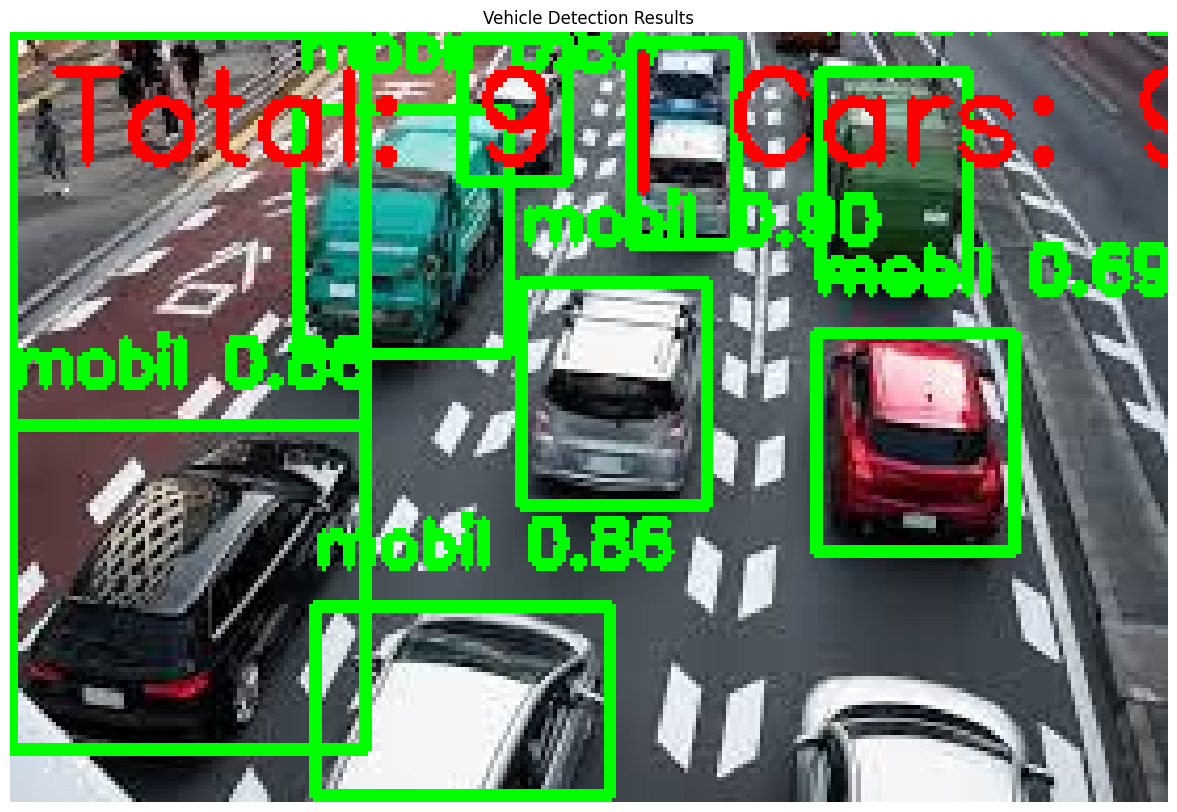


Detection Results:
Total vehicles: 9
Cars: 9
Motorcycles: 0
Recommended Green Signal Time: 37 seconds


In [18]:
# Let's test with your new traffic image
test_image = Path("images.jpeg")  # Use the image in the current directory

# Process the image
print(f"Processing image: {test_image.name}")
detect_vehicles_in_image(test_image)

# Save Trained Model

Let's save our trained model so we can use it later without retraining

In [ ]:
# Create a directory for saving models if it doesn't exist
save_dir = Path('saved_models')
save_dir.mkdir(exist_ok=True)

# Save the model in PyTorch format
model_name = 'vehicle_detector'
torch_path = save_dir / f'{model_name}.pt'
model.save(str(torch_path))
print(f"Model saved in PyTorch format at: {torch_path}")
print("\nModel saving complete! You can use this file for future inference without retraining.") 

Model saved in PyTorch format at: saved_models\vehicle_detector.pt

Model saving complete! You can use this file for future inference without retraining.
